In [22]:
from qiskit import QuantumCircuit, execute, Aer, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
import numpy as np
import os
from getpass import getpass
from quantuminspire.credentials import enable_account
from quantuminspire.credentials import get_authentication
from quantuminspire.qiskit import QI
import matplotlib.pyplot as plt

QI_URL = os.getenv('QI_URL', 'https://api.quantum-inspire.com/')

with open('CREDENTIAL.txt', 'r') as fh:
    enable_account( fh.read().replace('\n', '') )
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL)
qi_backend = QI.get_backend('QX single-node simulator')
starmon_backend = QI.get_backend('Starmon-5')

def print_state(dense_state):
    """
    Prints a *dense_state* with kets. Compatible with quimb states.

    Parameters
    ----------
    dense_state: array_like
            Dense representation of a quantum state

    Returns
    -------
    None: None
    """

    NN = int(np.log2(len(dense_state)))

    binaries = [bin(ii)[2:] for ii in range(2**NN)]
    binaries = ['0'*(NN-len(a)) + a for a in binaries] #Pad with 0s

    ket = []
    for ii, coef in enumerate(dense_state):
        if not np.isclose(np.abs(coef), 0.):
            if np.isclose(np.imag(coef), 0.):
                if np.isclose(np.real(coef), 1.):
                    ket.append('|{}>'.format(binaries[ii]))
                else:
                    ket.append('{:.3f}|{}>'.format(np.real(coef), binaries[ii]))
            else:
                ket.append('{:.3f}|{}>'.format(coef, binaries[ii]))
    print(' + '.join(ket))

def qiskit_get_statevect(qc, backend = Aer.get_backend('statevector_simulator')):
    """
        Returns the statevector of the qiskit quantum circuit *qc*

        Parameters
        ----------
        qc: Quantum circuit
            Quantum circuit of which we want the statevector

        Returns
        -------
        st: array_like
            Statevector of the quantum circuit after the application
            of the reverse operation on the qubit's ordering
    """
    statevector = execute(qc, backend).result()
    statevector = statevector.get_statevector()

    return statevector

We first create a bell state with all the 5 qubits. Notice that we have a connectivity map with a X

In [28]:
qreg = QuantumRegister(5)
creg = ClassicalRegister(5)
qc = QuantumCircuit( qreg, creg)

qc.h(2)
for ii in range(5):
    if ii==2:
        continue
    qc.cx(2, ii)

qc.h(2)
qc.cz(0, 2)
qc.measure(2, 2)
qc.barrier()

for ii in range(5):
    qc.measure(ii, ii)

print(qc)

            ┌───┐                           ░ ┌─┐            
q31_0: ─────┤ X ├─────────────────────■─────░─┤M├────────────
            └─┬─┘┌───┐                │     ░ └╥┘┌─┐         
q31_1: ───────┼──┤ X ├────────────────┼─────░──╫─┤M├─────────
       ┌───┐  │  └─┬─┘          ┌───┐ │ ┌─┐ ░  ║ └╥┘┌─┐      
q31_2: ┤ H ├──■────■────■────■──┤ H ├─■─┤M├─░──╫──╫─┤M├──────
       └───┘          ┌─┴─┐  │  └───┘   └╥┘ ░  ║  ║ └╥┘┌─┐   
q31_3: ───────────────┤ X ├──┼───────────╫──░──╫──╫──╫─┤M├───
                      └───┘┌─┴─┐         ║  ░  ║  ║  ║ └╥┘┌─┐
q31_4: ────────────────────┤ X ├─────────╫──░──╫──╫──╫──╫─┤M├
                           └───┘         ║  ░  ║  ║  ║  ║ └╥┘
 c5: 5/══════════════════════════════════╩═════╩══╩══╩══╩══╩═
                                         2     0  1  2  3  4 


In [26]:
#statevect = qiskit_get_statevect(qc, qi_backend)
statevector = execute(qc, starmon_backend).result()
#print_state(statevect)

ApiError: Gate reset not supported

{'00000': 225, '00001': 17, '00010': 15, '00011': 1, '00100': 152, '00101': 11, '00110': 8, '00111': 12, '01000': 14, '01001': 2, '01010': 3, '01011': 16, '01100': 8, '01101': 2, '01110': 5, '01111': 20, '10000': 57, '10001': 10, '10010': 4, '10011': 22, '10100': 40, '10101': 18, '10110': 9, '10111': 42, '11000': 5, '11001': 20, '11010': 17, '11011': 100, '11100': 12, '11101': 26, '11110': 30, '11111': 101}


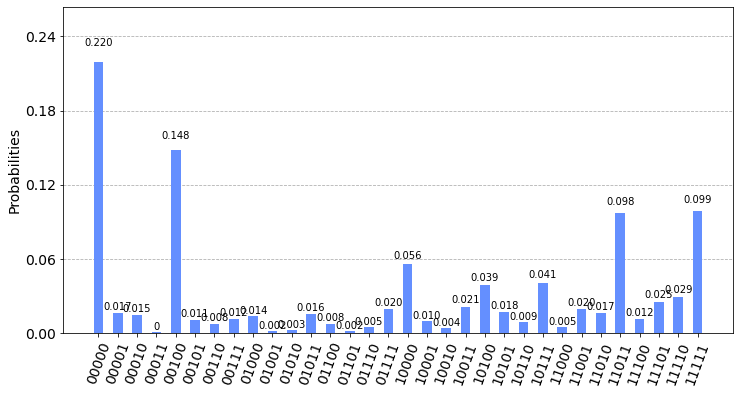

In [30]:
counts = statevector.get_counts()

plot_histogram( statevector.get_counts(), figsize=(12, 6) )
plt.show()

In [86]:
qc1 = qc.copy()

# Insert bit-flip error
qc1.x(0)

# Syndrome measurement
qc1.reset(2)
qc1.cx(0, 2)
qc1.cx(1, 2)
#qc1.cx(3, 2)
#qc1.cx(4, 2)
#qc1.measure(2, 0)
#qc1.x(0).c_if(creg, 1)

print(qc1)

statevect = qiskit_get_statevect(qc1)
print_state(statevect)

             ┌───┐                           ░ ┌───┐          
q220_0: ─────┤ X ├─────────────────────■─────░─┤ X ├──■───────
             └─┬─┘┌───┐                │     ░ └───┘  │       
q220_1: ───────┼──┤ X ├────────────────┼─────░────────┼────■──
        ┌───┐  │  └─┬─┘          ┌───┐ │ ┌─┐ ░      ┌─┴─┐┌─┴─┐
q220_2: ┤ H ├──■────■────■────■──┤ H ├─■─┤M├─░──|0>─┤ X ├┤ X ├
        └───┘          ┌─┴─┐  │  └───┘   └╥┘ ░      └───┘└───┘
q220_3: ───────────────┤ X ├──┼───────────╫──░────────────────
                       └───┘┌─┴─┐         ║  ░                
q220_4: ────────────────────┤ X ├─────────╫──░────────────────
                            └───┘         ║  ░                
  c2: 1/══════════════════════════════════╩═══════════════════
                                          0                   
0.707|00101> + 0.707|11110>


In [87]:
cbit = creg[0]

In [11]:
QI.backends()

[<QuantumInspireBackend('Spin-2')>,
 <QuantumInspireBackend('Starmon-5')>,
 <QuantumInspireBackend('QX-34-L')>,
 <QuantumInspireBackend('QX single-node simulator')>]